<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

# TP1 Instructions


The goal of this TP is to work on a mortality prediction problem and to participate into the "To be or not to be?" challenge.

A fresh instance of the challenge can be found here: https://competitions.codalab.org/competitions/27605

* **Step 1:** Sign up to https://competitions.codalab.org
* **Step 2:** Go through the competition's pages and read them carefully in order to understand the problem.
* **Step 3:** Download the dataset from "Participate > Files > Public Data" page. Put the "public_data" folder in the same folder as the folder containing this notebook.
* **Step 4:** Go though this notebook. You'll have to read, run, **code your own methods** and **answer quetions**. Use "code" cell for coding and "markdown" cell to answer questions. 

_Remark: You may need to look up on the internet for information or documentation._

<b><font size="5">Outline</font></b><br/><br/>
&emsp;&emsp;&emsp; I) <a href="#data"> Load data</a><br/>
&emsp;&emsp;&emsp; II) <a href="#exploratory"> Exploratory analysis </a><br/>
&emsp;&emsp;&emsp; III) <a href="#processing"> Processing </a><br/>
&emsp;&emsp;&emsp; IV) <a href="#model"> Predictive model </a><br/>
&emsp;&emsp;&emsp; V) <a href="#save"> Save predictions </a><br/>

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import time
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np

# IMPORTS
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

### Question 1: Briefly explain the task.

We are to classify patients according to their given information into people who will survive vs people who will have died. This way we might be able to predict who needs more attention 

### Question 2: What is the metric used in the challenge?


The metric that is used accuracy, the percentage of rightfully classified instances. In balanced accuracy missclassifing(or rightly classifying for that matter) a class that is less represented has a stronger influence on the accuracy score to prevent models to simply learn to answer with the most represented class.

### Question 3: What is up-sampling? Why it may be worth a try for this problem?

When upsampling one amplifies the signal of a class by reusing instances of it in the learning process. This is interesting for this task since we have very little data for the class of people who died in the hospital. Reusing some of the "dead" cases trains the model to make more balanced predictions.


# 1. Load data

In [2]:
features = pd.read_csv(
    "../public_data/mimic_synthetic_feat.name", header=None
).values.flatten()
labels = pd.read_csv(
    "../public_data/mimic_synthetic_label.name", header=None
).values.flatten()
X = pd.read_csv(
    "../public_data/mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)
y = pd.Series(
    pd.read_csv(
        "../public_data/mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [3]:
X.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,45524,108398,2128-05-15_23:42:00,2132-07-23_15:00:00,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,...,0,0,0,0,0,0.0,0,0,0,0
1,50520,186416,2134-03-17_03:59:00,2113-03-06_12:05:00,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,...,0,0,0,0,0,0.0,0,0,0,1
2,17956,126413,2164-04-05_17:32:00,2180-09-20_16:30:00,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,...,0,0,0,0,0,0.0,0,0,0,0
3,90258,109355,2102-09-08_00:58:00,2166-06-26_15:30:00,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,...,0,0,0,0,0,0.0,0,0,1,0
4,25159,123784,2163-08-06_12:07:00,2147-01-14_18:40:00,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,...,0,0,0,0,0,0.0,0,0,0,0


This is the **training set**. This means that have access to the labels and you can use it in anyway you want to prepare your model.

Later on, you'll make your model draws predictions from the **testing set** in order to upload them on Codalab and get a score on unseen labels.

In [4]:
# Load testing set
X_test = pd.read_csv(
    "../public_data/mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

#### Variable types

In [5]:
types = pd.read_csv(
    "../public_data/mimic_synthetic_feat.type", header=None
).set_index(features)[0]
print(types.value_counts())

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64


# 2. Pre-processing

Include here any code, text, or plot related to the data pre-processing such as dimensionality reduction,
encoding, etc.

In [6]:
pd.unique(X[['Tuberculosis', 'Immuniz/scrn', 'AcuteMI', 'Coronathero', 'Chestpain', 'Pulmhartdx', 'Othheartdx', 'Conduction', 'Dysrhythmia', 'Cardiaarrst', 'chf;nonhp', 'AcuteCVD', 'Hd/nckcancr', 'Precereoccl', 'OtherCVD', 'TIA', 'LateeffCVD', 'Peripathero', 'Aneurysm', 'Artembolism', 'Otcirculdx', 'Phlebitis', 'Varicosevn', 'Esophcancer', 'Hemmorhoids', 'Othveindx', 'Pneumonia', 'Influenza', 'Tonsillitis', 'Bronchitis', 'Otuprspin', 'COPD', 'Asthma', 'Asppneumon', 'Stomchcancr', 'Pleurisy', 'Adltrespfl', 'Lungexternl', 'Othlowresp', 'Otupprresp', 'Intestinfct', 'Teethdx', 'Mouthdx', 'Esophgealdx', 'Gasduoulcer', 'Coloncancer', 'Gastritis', 'Otdxstomch', 'Appendicitis', 'Abdomhernia', 'Ulceratcol', 'Intobstruct', 'Diverticulos', 'Anal/rectal', 'Peritonitis', 'Biliarydx', 'Rctm/anusca', 'Othliverdx', 'Pancreasdx', 'GIhemorrhag', 'Gastroent', 'OtherGIdx', 'Nephritis', 'Acrenlfail', 'Chrrenfail', 'UTI', 'Liver/ibdca', 'Urinstone', 'Otdxkidney', 'Otdxbladdr', 'OtherGUdx', 'BPH', 'Infmalegen', 'Othmalegen', 'Breastdx', 'PID', 'Endometrios', 'Pancreascan', 'Prolapse', 'Menstrualdx', 'Ovariancyst', 'Menopausldx', 'Feminfertil', 'Otfemalgen', 'Contraceptiv', 'Spontabortn', 'Inducabortn', 'Abortcompl', 'GI/peritcan', 'Ectopicpreg', 'Otpregcomp', 'Hemorrpreg', 'HTNinpreg', 'Earlylabor', 'Longpregncy', 'DMinpreg', 'Malposition', 'Pelvicobstr', 'Prevc-sectn', 'Brnch/lngca', 'Fetaldistrs', 'Amniosdx', 'Umbilcord', 'OB-relatedperintrauma', 'Otcomplbir', 'Nmlpreg/del', 'Skininfectn', 'Otinflskin', 'Ulcerskin', 'Septicemia', 'Otrespirca', 'Othskindx', 'Infectarth', 'Rheumarth', 'Osteoarthros', 'Otjointdx', 'Backproblem', 'Osteoporosis', 'Pathologfx', 'Acqfootdef', 'Otacqdefor', 'Bone/ctcncr', 'SLE', 'Otconntiss', 'Otbonedx', 'Cardiacanom', 'GIconganom', 'guconganom', 'Nervcongan', 'Otconganom', 'Liveborn', 'Lowbirthwt', 'Skinmelanom', 'Birthasphyx', 'Respdistres', 'Perintjaund', 'Birthtrauma', 'Otperintdx', 'Jointinjury', 'Fxhip', 'Spincorinj', 'Fxskullfac', 'Fxarm', 'Non-epithca', 'Fxleg', 'Othfracture', 'Sprain', 'Intracrninj', 'Crushinjury', 'Opnwndhead', 'Opnwndextr', 'Complicdevi', 'Complicproc', 'Superficinj', 'Breastcancr', 'Burns', 'Poisonpsych', 'Poisnotmed', 'Poisnnonmed', 'Otherinjury', 'Syncope', 'FUO', 'Lymphenlarg', 'Gangrene', 'Shock', 'Uteruscancr', 'Nausea/vomit', 'Abdomnlpain', 'Fatigue', 'Allergy', 'Socialadmin', 'Exam/eval', 'Otaftercare', 'Otherscreen', 'Unclassified', 'Cervixcancr', 'ECodes:Cut/pierce', 'ECodes:Drowning/submersion', 'ECodes:Fall', 'ECodes:Fire/burn', 'ECodes:Firearm', 'ECodes:Machinery', 'ecodes:motorvehicletraffic(mvt)', 'ECodes:Pedalcyclist-notMVT', 'ECodes:Pedestrian-notMVT', 'ecodes:transport-notmvt', 'ECodes:Natural/environment', 'ECodes:Overexertion', 'ECodes:Poisoning', 'ECodes:Struckby-against', 'ECodes:Suffocation', 'ECodes:Adverseeffectsofmedicalcare', 'ECodes:Adverseeffectsofmedicaldrugs', 'ECodes:Otherspecifiedandclassifiable', 'ecodes:otherspecified-nec', 'ECodes:Unspecified', 'ECodes:Placeofoccurrence', 'Ovarycancer', 'Femgenitca', 'Prostatecan', 'Othbactinf', 'Testiscancr', 'Malgenitca', 'Bladdercncr', 'Kidny/rnlca', 'Urinyorgca', 'Brain/nscan', 'Thyroidcncr', 'Hodgkin-sds', 'Non-Hodglym', 'Leukemias', 'Mycoses', 'Multmyeloma', 'Otprimryca', '2ndarymalig', 'Maligneopls', 'Neoplsmunsp', 'Maintchem/r', 'Bnignutneo', 'Otbnignneo', 'Thyroiddsor', 'DiabMelnoc', 'HIVinfectn', 'DiabMelw/cm', 'Otendodsor', 'Nutritdefic', 'Hyperlipidem', 'Gout/otcrys', 'Fluid/elcdx', 'Cysticfibro', 'Immunitydx', 'Otnutritdx', 'Anemia', 'Hepatitis', 'Acutp-hanm', 'Sicklecell', 'Coag/hemrdx', 'Whtblooddx', 'Othematldx', 'Adjustmentdisorders', 'Anxietydisorders', 'Attention-deficit/conduct/disruptivebeha', 'Delirium/dementia/amnestic/othercognitiv', 'Developmentaldisorders', 'Disordersusuallydiagnosedininfancy/ch', 'ImpulsecontroldisordersNEC', 'Mooddisorders', 'Personalitydisorders', 'Schizophreniaandotherpsychoticdisorde', 'Alcohol-relateddisorders', 'Substance-relateddisorders', 'Suicideandintentionalself-inflictedin', 'Screeningandhistoryofmentalhealthan', 'Miscellaneousmentaldisorders', 'Viralinfect', 'Meningitis', 'Encephalitis', 'OthCNSinfx', 'Parkinson-s', 'Othinfectns', 'MS', 'OtheredCNS', 'Paralysis', 'Epilepsy/cnv', 'Headache/mig', 'Coma/brndmg', 'Cataract', 'Retinaldx', 'Glaucoma', 'Blindness', 'SexualInfxs', 'Eyeinfectn', 'Othereyedx', 'Otitismedia', 'Dizziness', 'Othereardx', 'Othnervdx', 'Hrtvalvedx', 'Carditis', 'HTN', 'Htncomplicn']].values.ravel('K'))


array([ 0.,  1., nan])

We decided to create an other feature: length stay.
For the encoding we use the function cat.codes which encode object in number

In [7]:
columns = X.columns[X.dtypes == 'object'].tolist() + ["AGE"]
def clearing(df):
    df = df.copy()
    cols = ['SUBJECT_ID', 'HADM_ID', "PID"]#[col for col in df.columns if "ID" in col]
    for col in cols:
        df.pop(col)
    df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"].apply(lambda a: a.replace("_", " "))).apply(lambda x:x.timestamp())
    df["DISCHTIME"] = pd.to_datetime(df["DISCHTIME"].apply(lambda a: a.replace("_", " "))).apply(lambda x:x.timestamp())
    df["length_stay"] = df["DISCHTIME"] - df["ADMITTIME"]
    df["length_stay"] = (df["length_stay"] - df["length_stay"].min())/(df["length_stay"].max() - df["length_stay"].min())
    df["ADMITTIME"] = (df["ADMITTIME"] - df["ADMITTIME"].min())/(df["ADMITTIME"].max() - df["ADMITTIME"].min())
    df["DISCHTIME"] = (df["DISCHTIME"] - df["DISCHTIME"].min())/(df["DISCHTIME"].max() - df["DISCHTIME"].min())
    df = pd.get_dummies(df)
#     df.pop('ADMITTIME')
#     df.pop('DISCHTIME')
#     columns = df.columns[df.dtypes == 'object']
#     for column in columns:
#         df[column] = df[column].astype('category').cat.codes
        

    return df

df = clearing(X)
df

,ADMITTIME,DISCHTIME,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,...,ETHNICITY_WHITE_-_EASTERN_EUROPEAN,ETHNICITY_WHITE_-_OTHER_EUROPEAN,ETHNICITY_WHITE_-_RUSSIAN,GENDER_F,GENDER_M,ICU_CCU,ICU_CSRU,ICU_MICU,ICU_SICU,ICU_TSICU
0,0.258189,0.296698,21,57.207630,108.704030,70.841980,79.847060,119.72417,94.435090,26.880910,...,0,0,0,1,0,0,0,0,1,0
1,0.312119,0.117548,39,79.331400,121.138664,96.915726,93.994540,138.59406,113.570206,38.621536,...,0,0,0,0,1,1,0,0,0,0
2,0.589911,0.741872,40,118.230290,175.175430,140.936700,122.862610,144.25964,134.501220,67.754650,...,0,0,0,0,1,0,0,1,0,0
3,0.020775,0.610275,75,83.780380,89.188980,86.051155,111.390740,144.86057,127.681170,61.139935,...,0,0,0,0,1,1,0,0,0,0
4,0.583756,0.430524,55,60.878613,105.637500,80.616840,87.627464,127.75874,99.098860,42.693020,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,0.888767,0.320283,76,56.035793,97.863950,79.709885,77.546234,120.30758,102.489240,26.716347,...,0,0,0,1,0,0,1,0,0,0
79995,0.622278,0.189879,38,55.126850,86.027390,67.647910,83.051470,174.83446,119.396470,40.401726,...,0,0,0,1,0,0,0,0,0,1
79996,0.395761,0.380310,90,74.281746,91.267840,91.425380,95.857544,138.79803,130.716320,52.676624,...,0,0,0,1,0,0,0,0,1,0
79997,0.771614,0.010479,57,79.256140,128.995130,98.742550,107.726430,141.92834,132.398940,57.103550,...,0,0,0,0,1,0,0,0,0,1


Here are two functions for resampling but in practice, we don't use them

In [8]:
#down  sampling; throw away some of the data
def down_sample(df, labels):
    pos_number = labels.sum()
    new_labels = labels.loc[labels == 1]
    new_labels = new_labels.append(labels.loc[labels==0].sample(pos_number))
    return df.loc[new_labels.index].reset_index(), new_labels.reset_index()

#up sampling, copying rows with a positive values
def up_sample(df, labels, length=1500):
    new_labels = labels.loc[labels==1].sample(length)
    new_df = df.append(df.loc[new_labels.index])
    return new_df.reset_index(), new_labels.reset_index()
    
A = down_sample(X,y)
B = up_sample(X,y,1000)

In [9]:
X_encoded = clearing(X)

In [10]:
X_encoded.shape

(79999, 480)

In [11]:
X_encoded

,ADMITTIME,DISCHTIME,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,...,ETHNICITY_WHITE_-_EASTERN_EUROPEAN,ETHNICITY_WHITE_-_OTHER_EUROPEAN,ETHNICITY_WHITE_-_RUSSIAN,GENDER_F,GENDER_M,ICU_CCU,ICU_CSRU,ICU_MICU,ICU_SICU,ICU_TSICU
0,0.258189,0.296698,21,57.207630,108.704030,70.841980,79.847060,119.72417,94.435090,26.880910,...,0,0,0,1,0,0,0,0,1,0
1,0.312119,0.117548,39,79.331400,121.138664,96.915726,93.994540,138.59406,113.570206,38.621536,...,0,0,0,0,1,1,0,0,0,0
2,0.589911,0.741872,40,118.230290,175.175430,140.936700,122.862610,144.25964,134.501220,67.754650,...,0,0,0,0,1,0,0,1,0,0
3,0.020775,0.610275,75,83.780380,89.188980,86.051155,111.390740,144.86057,127.681170,61.139935,...,0,0,0,0,1,1,0,0,0,0
4,0.583756,0.430524,55,60.878613,105.637500,80.616840,87.627464,127.75874,99.098860,42.693020,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,0.888767,0.320283,76,56.035793,97.863950,79.709885,77.546234,120.30758,102.489240,26.716347,...,0,0,0,1,0,0,1,0,0,0
79995,0.622278,0.189879,38,55.126850,86.027390,67.647910,83.051470,174.83446,119.396470,40.401726,...,0,0,0,1,0,0,0,0,0,1
79996,0.395761,0.380310,90,74.281746,91.267840,91.425380,95.857544,138.79803,130.716320,52.676624,...,0,0,0,1,0,0,0,0,1,0
79997,0.771614,0.010479,57,79.256140,128.995130,98.742550,107.726430,141.92834,132.398940,57.103550,...,0,0,0,0,1,0,0,0,0,1


In [12]:
X_test_encoded = clearing(X_test)

In [13]:
X_test_encoded = X_test_encoded.reindex(columns = X_encoded.columns, fill_value=0)

In [14]:
X_encoded = X_encoded.reindex(columns = X_test_encoded.columns, fill_value=0)

We decided to fill the Nan values with the pad method

In [15]:
X_test_encoded = X_test_encoded.fillna(method="pad")#(X.mean())#(method="pad")
X_encoded = X_encoded.fillna(method="pad")#(X_encoded.mean())#(method="pad")

In [16]:
nan_values = X_encoded.isna()
nan_columns = nan_values.any()

columns_with_nan = X_encoded.columns[nan_columns].tolist()
print(columns_with_nan)

[]


In [17]:
[col for col in X_encoded.columns if "ID" in col]

['LANGUAGE_*YID', 'MARITAL_STATUS_WIDOWED', 'ETHNICITY_MIDDLE_EASTERN']

In [18]:
X["PID"].value_counts()

0    79999
Name: PID, dtype: int64

Here is a functon to normlize the data with standarsization

In [19]:
saved = {}
def normalize(df, use_saved=False):
    result = df.copy()
    for feature_name in df.columns :
        if feature_name not in columns:
            if use_saved:
                std_value, mean_value = saved[feature_name]
            else:
                std_value = df[feature_name].std()
                mean_value = df[feature_name].mean()
                saved[feature_name] = (std_value, mean_value)
            second = std_value
            if second == 0:
                result[feature_name] = 0
            else:
                result[feature_name] = (df[feature_name] - mean_value) / second
    return result


We tried a PCA but it was not really useful so we decided to don't use it

In [20]:
from sklearn.decomposition import PCA
X_encoded_copy = X_encoded.copy()


# mod = PCA(100)
# X_encoded_copy = mod.fit_transform(X_encoded_copy)

X_encoded_copy = normalize(X_encoded_copy)
# X_encoded_copy = X_encoded_copy[df_upsampled.columns[important_features_list[:20]].tolist()]


In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X_encoded_copy, y, test_size=0.2
)  # train/validation split

Here is our actual resmapling

In [22]:
from sklearn.utils import resample


df_majority = x_train[y_train==0]
df_minority = x_train[y_train==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(df_majority.shape[0]),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

new_y = np.concatenate([np.zeros(df_majority.shape[0]), np.ones(df_minority_upsampled.shape[0])])


df_upsampled.shape, df_majority.shape, df_minority_upsampled.shape, y_train.shape, new_y.shape

((123544, 480), (61772, 480), (61772, 480), (63999,), (123544,))

# 3. Model

Include here any code, text, or plot related to the classification algorithm(s), the hyperparameters, the validation
method, etc.

In [23]:
from sklearn.svm import SVC, LinearSVC
from  sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np

clf = XGBClassifier(n_estimators=20, max_depth=5, n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
# clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# clf = LogisticRegression(solver="saga", penalty="l2", fit_intercept=True)
# clf = SVC()
# clf = LinearSVC(random_state=0, tol=1e-5, max_iter=100, dual=False)


We fist try with logistic regression with differenct parameters. The best configuration is with penalty="l2" and solver="saga". Our accuracy on the validation test is about 0.74

In [36]:
clf = LogisticRegression(solver="saga", penalty="l2", max_iter=1000 ,fit_intercept=True).fit(df_upsampled, new_y)
y_pred = clf.predict(x_valid)
logistic_score = balanced_accuracy_score(y_valid, y_pred)
print(logistic_score)

0.7425517364731202


We try the Linear SVC with different parameters. Our best accuracy was 0.74 too on the validation set with the parameters dual=false, max_iter=100

In [39]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC

clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter=100, dual=False))
clf.fit(df_upsampled, new_y)
y_pred = clf.predict(x_valid)  # predictions
LinearSVC_score = balanced_accuracy_score(y_valid, abs(y_pred.round()))  # scoring
print(LinearSVC_score)

0.7440961840273659


In [33]:
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = ["balanced"]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap, 
               'class_weight': class_weight} 


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = 4)# Fit the random search model
rf_random.fit(df_upsampled, new_y)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.0min


In [37]:


n_estimators = [10, 20, 30, 50, 80, 100, 200, 300, 500]
max_depth=[1,2,3,4,5,6]#,7,9,11,13,15,20,25,30,40,50]
seed=42

res = []
clf = XGBClassifier(n_estimators=1, max_depth=1, n_jobs=-1, tree_method='gpu_hist', gpu_id=0, seed=seed)

for n in n_estimators:
    for mx in max_depth:
        print("n_estimators", n, "max_depth", mx)
        clf.__init__(n_estimators=n, max_depth=mx, n_jobs=-1, tree_method='gpu_hist', gpu_id=0, seed=seed)
        clf.fit(df_upsampled, new_y)  # training
        y_pred = clf.predict(x_valid)  # predictions
        score = balanced_accuracy_score(y_valid, y_pred)  # scoring
        print("Balanced accuracy score: {}".format(score))
        res.append({"n_estimators": n, "max_depth":mx, "score":score})
#         clf.del()
#         del clf

In [36]:
res = sorted(res, key=lambda a: a["score"], reverse=True)
print("Best XGBoost model", res[0])

Best XGBoost model {'n_estimators': 500, 'max_depth': 2, 'score': 0.7587731019228132}


XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. As well as, this model uses tree structure, and so far it is one of the most promising models in machine learning world
In this experiment we optimized such parameters:
- n_estimators: number of estimators for XGBoost classifier
- max_depth: Maximum tree depth for base learners.

As best results we got not very deep tree model with 500 estimators which are maximum 2 depth trees. THe best result is 0.758 which is in top-10 in challange.

In [24]:
clf.fit(df_upsampled, new_y)  # training
y_pred = clf.predict(x_valid)  # predictions
score = balanced_accuracy_score(y_valid, y_pred)  # scoring
print("Balanced accuracy score: {}".format(score))

Balanced accuracy score: 0.7250747575354459


In [ ]:
important_features_dict = {}
for x,i in enumerate(clf.feature_importances_):
    important_features_dict[x]=i

important_features_dict = dict(sorted(important_features_dict.items(), key=lambda item: item[1], reverse=True))
print(important_features_dict)
# important_features_list = sorted(important_features_dict,
#                                  key=important_features_dict.get,
#                                  reverse=False)
important_features_list = list(important_features_dict.keys())
df_upsampled.columns[important_features_list].tolist()

In [30]:
from keras.callbacks import Callback

class MyLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(x_valid).reshape(-1)  # predictions
        y_pred[y_pred <= 0.5] = 0
        y_pred[y_pred>0.5] = 1
        score = balanced_accuracy_score(y_valid, y_pred)  # scoring
        print("Balanced accuracy score: {}".format(score))

model = new_model([16,8])
history = model.fit(df_upsampled, new_y, epochs=20, batch_size=1024, validation_data=(x_valid, y_valid), callbacks=[MyLogger()])

Train on 123544 samples, validate on 16000 samples
Epoch 1/20
123544/123544 [==============================] - 2s 12us/step - loss: 0.6788 - accuracy: 0.5705 - val_loss: 0.5588 - val_accuracy: 0.7958
Balanced accuracy score: 0.715884412911735
Epoch 2/20
123544/123544 [==============================] - 1s 9us/step - loss: 0.5974 - accuracy: 0.6867 - val_loss: 0.4331 - val_accuracy: 0.8264
Balanced accuracy score: 0.7427448238223556
Epoch 3/20
123544/123544 [==============================] - 1s 9us/step - loss: 0.5492 - accuracy: 0.7321 - val_loss: 0.4510 - val_accuracy: 0.8020
Balanced accuracy score: 0.7596423008265967
Epoch 4/20
123544/123544 [==============================] - 1s 9us/step - loss: 0.5284 - accuracy: 0.7467 - val_loss: 0.4340 - val_accuracy: 0.8110
Balanced accuracy score: 0.7643085354345033
Epoch 5/20
123544/123544 [==============================] - 1s 9us/step - loss: 0.5160 - accuracy: 0.7542 - val_loss: 0.4741 - val_accuracy: 0.7798
Balanced accuracy score: 0.769258

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

from keras.callbacks import Callback

class MyLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = model.predict(x_valid).reshape(-1)  # predictions
        y_pred[y_pred <= 0.5] = 0
        y_pred[y_pred>0.5] = 1
        score = balanced_accuracy_score(y_valid, y_pred)  # scoring
        print("Balanced accuracy score: {}".format(score))
        model.accurs.append(score)

def new_model(layers, dropout=0.5, lr=0.001):
    model = Sequential()
    
    
    for i, layer in enumerate(layers):
        if i == 0:
            model.add(Dense(layer, input_dim=480))
        else:
            model.add(Dense(layer))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dropout))


    model.add(Dense(1, activation='sigmoid'))
    
    optim = Adam(lr=lr)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [28]:
from itertools import combinations  
from itertools import permutations  
from keras import backend as K

inp = [8,16,32,64,128]
lrs = [0.001, 0.005, 0.0001]
dropouts = [0.5, 0.2, 0.7]
    
perm = list(permutations(inp)) 
perm = [sorted(p, reverse=True) for p in perm]
perm = np.unique(perm, axis=0).tolist()

for i in range(2, len(inp)):
    comb = list(combinations(inp, i))
    comb = np.unique(comb, axis=0).tolist()
    comb = [sorted(c, reverse=True) for c in comb]

    perm = perm + comb

res = []
for lr in lrs:
    for drop in dropouts:
        for pair in perm:
            print(pair, "lr",lr, "dropout_rate",drop)
            model = new_model(pair, lr=lr, dropout=drop)
            model.accurs = []
            history = model.fit(df_upsampled.values, new_y, epochs=20, batch_size=2048, validation_data=(x_valid, y_valid), callbacks=[MyLogger()], verbose=0)
            y_pred = model.predict(x_valid).reshape(-1)  # predictions
            y_pred[y_pred <= 0.5] = 0
            y_pred[y_pred>0.5] = 1
            score = balanced_accuracy_score(y_valid, y_pred)  # scoring
            res.append({"pair":pair, "lr":lr, "dropout_rate":drop, "history":history, "accurs":model.accurs, "max_score":max(model.accurs)})
            del model
            K.clear_session()

[128, 64, 32, 16, 8] lr 0.001 dropout_rate 0.5
Balanced accuracy score: 0.5530408977726233
Balanced accuracy score: 0.694060897545224
Balanced accuracy score: 0.7007470068560904
Balanced accuracy score: 0.6894509442757899
Balanced accuracy score: 0.6981512433059317
Balanced accuracy score: 0.7001603165398915
Balanced accuracy score: 0.6877551136428238
Balanced accuracy score: 0.6818671760412047
Balanced accuracy score: 0.7374879194096713
Balanced accuracy score: 0.7241822150970427
Balanced accuracy score: 0.7342406567293152
Balanced accuracy score: 0.7450790781230459
Balanced accuracy score: 0.7203289331559619
Balanced accuracy score: 0.7332872849654921
Balanced accuracy score: 0.7351388841514025
Balanced accuracy score: 0.7444218940091643
Balanced accuracy score: 0.7439176359563848
Balanced accuracy score: 0.7243954019851963
Balanced accuracy score: 0.7054655433138908
Balanced accuracy score: 0.7312253413832702
[16, 8] lr 0.001 dropout_rate 0.5
Balanced accuracy score: 0.6570743936964

KeyboardInterrupt: 

In [35]:
res = sorted(res, key=lambda a: a["max_score"], reverse=True)
print("Best DNN model", res[0])

Best DNN model {'pair': [128, 8], 'history': <keras.callbacks.callbacks.History object at 0x7f72317c75c0>, 'accurs': [0.6259853952991664, 0.741070684329272, 0.7355441932694866, 0.7455615141614771, 0.7623178699313663, 0.7645906629940811, 0.7529200159362901, 0.7577581006471822, 0.7739939228652399, 0.7778069255899176], 'max_score': 0.7778069255899176}


In [ ]:
def compute_accuracy(data, target, name="", disp=False):
    data = torch.FloatTensor(data).cuda()
    data = Variable(data)

    y_pred = net(data)
    y_pred = y_pred.detach().cpu().numpy().reshape(-1)  # predictions
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred>0.5] = 1
    score = balanced_accuracy_score(target, y_pred)  # scoring
    if disp: print(name, "balanced accuracy score: {}".format(score))
    return score

In [ ]:
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(340, 64)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 16)
        self.drop3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = F.relu(self.drop1(self.fc1(x)))
        x = F.relu(self.drop2(self.fc2(x)))
        x = F.relu(self.drop3(self.fc3(x)))
        x = self.fc4(x)
        return self.sigmoid(x)
    
net = Net().cuda()
learning_rate = 0.0001
epochs = 10
batch_size=1024
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# create a loss function
criterion = nn.BCELoss()

batch_count = df_upsampled.shape[0]/batch_size
if batch_count - int(batch_count)>0: batch_count = int(batch_count)+1
    
log_interval = batch_count

df_upsampled_values = df_upsampled.values




In [ ]:
for epoch in range(epochs*4):
    for batch_idx in range(batch_count):
        start, end = int(batch_idx*batch_size), int(batch_idx*batch_size+batch_size)
        data, target = df_upsampled_values[start:end], new_y[start:end].reshape((-1,1))
        data, target = torch.FloatTensor(data).cuda(), torch.Tensor(target).cuda()
        data, target = Variable(data), Variable(target)
        # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        data = data.view(-1, 340)
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            score = compute_accuracy(df_upsampled_values, new_y, name="Train", disp=False)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTrain accuracy: {:.6f}'.format(
                    epoch, batch_idx * len(data), df_upsampled.shape[0],
                           100. * batch_idx / batch_count, loss.detach().cpu().numpy(), score))
            
compute_accuracy(x_valid.values, y_valid.values, name="Test", disp=True)

In [ ]:
compute_accuracy(x_valid.values, y_valid.values, name="Test", disp=True)

In [ ]:
test_loss = 0
correct = 0
for data, target in zip(df_upsampled_values, new_y.reshape((-1,1))):
    data, target = data.reshape((1,-1)), target.reshape((-1,1))
    data, target = torch.FloatTensor(data).cuda(), torch.Tensor(target).cuda()
    data, target = Variable(data, volatile=True), Variable(target)
#     data = data.view(-1, 28 * 28)
    net_out = net(data)
    # sum up batch loss
#     print(net_out.shape, target.shape)
    test_loss += criterion(net_out, target).detach().cpu().numpy()
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    correct += pred.eq(target.data).sum()

test_loss /= df_upsampled_values.shape[0]
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

### Code 3: the code above uses a simple "hold out" method to get the validation score. Use cross-validation to get a more stable estimation.

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, df_upsampled, new_y, cv=5, scoring='f1_macro')

### Code 4: Try to improve your score by using at least one of the following methods:

* Hyperparameter search
* Model selection
* Data augmentation

In [ ]:
# TODO:
# Hyperparameter search
# Model selection
# Data augmentation

### Question 3: What is up-sampling? Why it may be worth a try for this problem?

TODO: answer
When upsampling one amplifies the signal of a class by reusing instances of it in the learning process. This is interesting for this task since we have very little data for the class of people who died in the hospital. Reusing some of the "dead" cases trains the model to make more balanced predictions.



In [ ]:
# 4. Visualization

#### Labels distribution

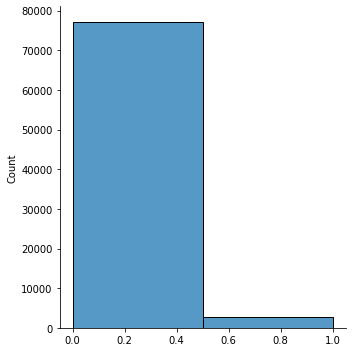

In [26]:
sns.displot(y, bins=2, kde=False)

We can see that before upsampling, the class were not well balanced

### Code 1: Display the following plots:
* Bar plots of some categorical variables (e.g. "LANGUAGE", "MARITAL_STATUS")

* Show the correlation between some variables and the target variable y.

* Another plot or any exploratory analysis you can think of

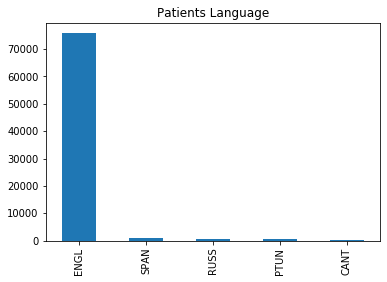

In [12]:
X['LANGUAGE'].value_counts()[:5].plot(kind='bar', title="Patients Language")

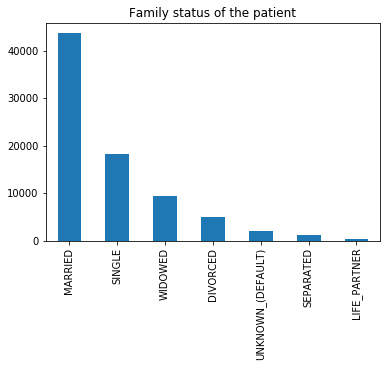

In [13]:
X['MARITAL_STATUS'].value_counts().plot(kind='bar', title="Family status of the patient")

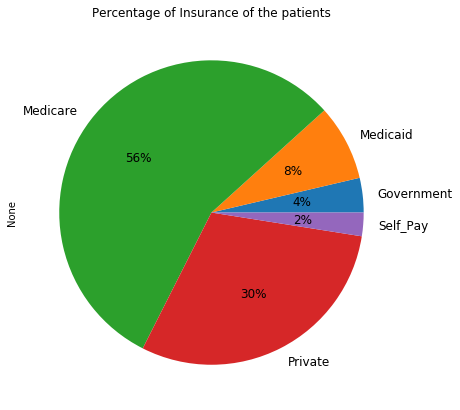

In [14]:
plt.figure(figsize=(7,7))
X.groupby('INSURANCE').size().plot(kind='pie',autopct='%1.0f%%',  textprops={'fontsize': 12}, title="Percentage of Insurance of the patients")
plt.show()

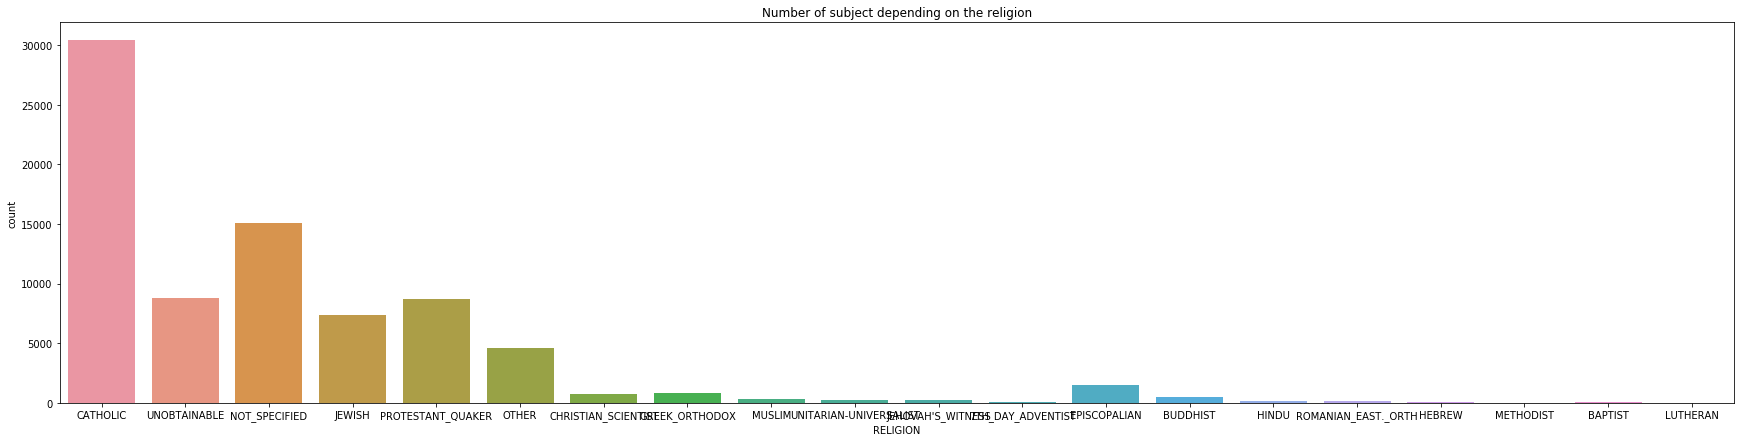

In [15]:
plt.figure(figsize=(30,7))

ax = sns.countplot(x="RELIGION", data=X).set_title("Number of subject depending on the religion")

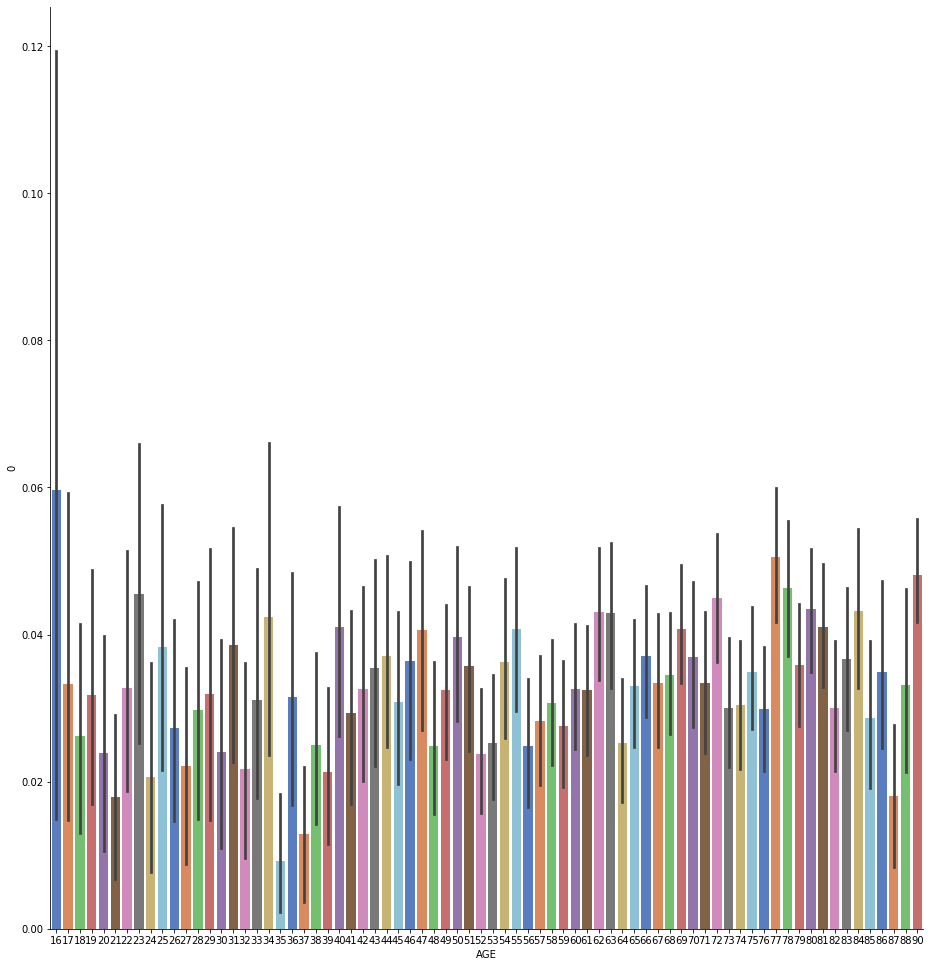

In [96]:

ages = X['AGE']
dlg = pd.concat([ages,y], axis=1)
g = sns.catplot(x="AGE", y=0,data=dlg, kind="bar", palette="muted")
g.fig.set_size_inches(15,15)

On this plot we can see the probability to die depending on the age

Text(0, 0.5, 'number of people alive')

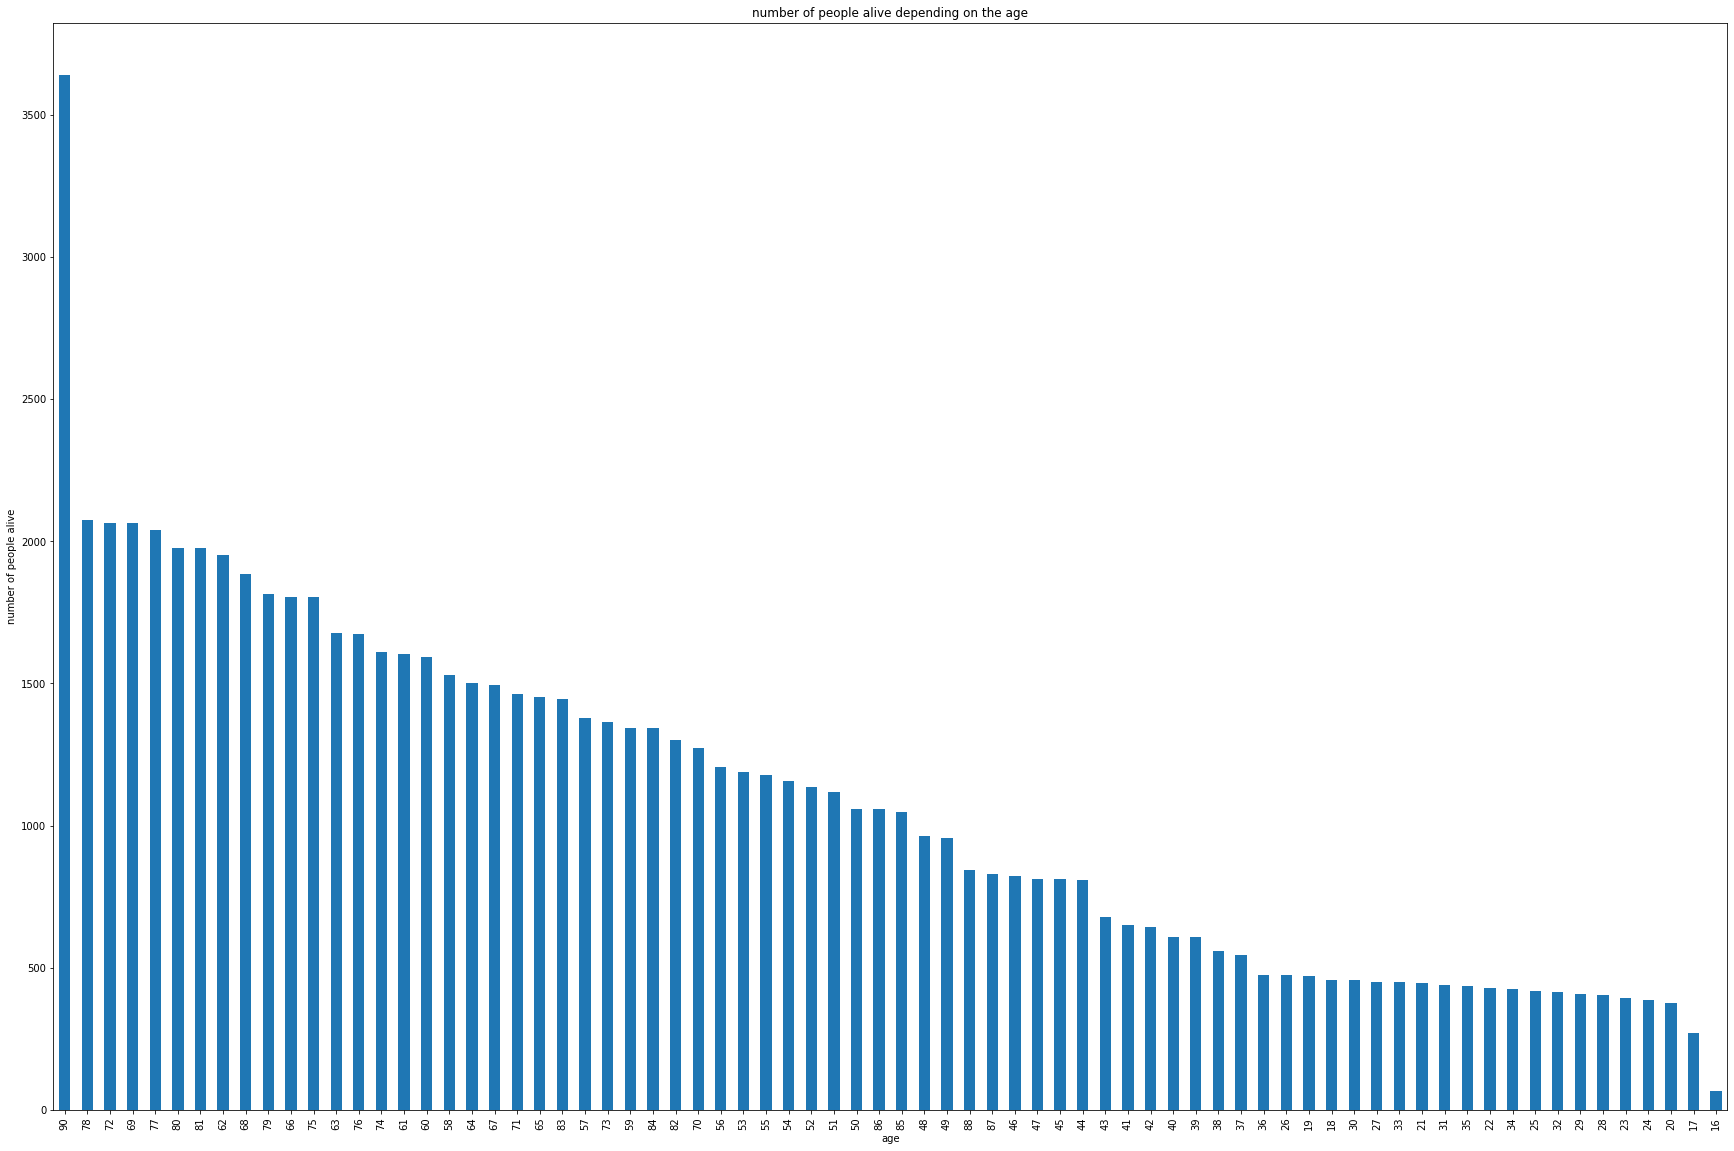

In [5]:
plt.figure(figsize=(30,20))

X["AGE"].value_counts().plot.bar()
plt.title("number of people alive depending on the age")
plt.xlabel("age")
plt.ylabel("number of people alive")

Text(0, 0.5, 'number of death')

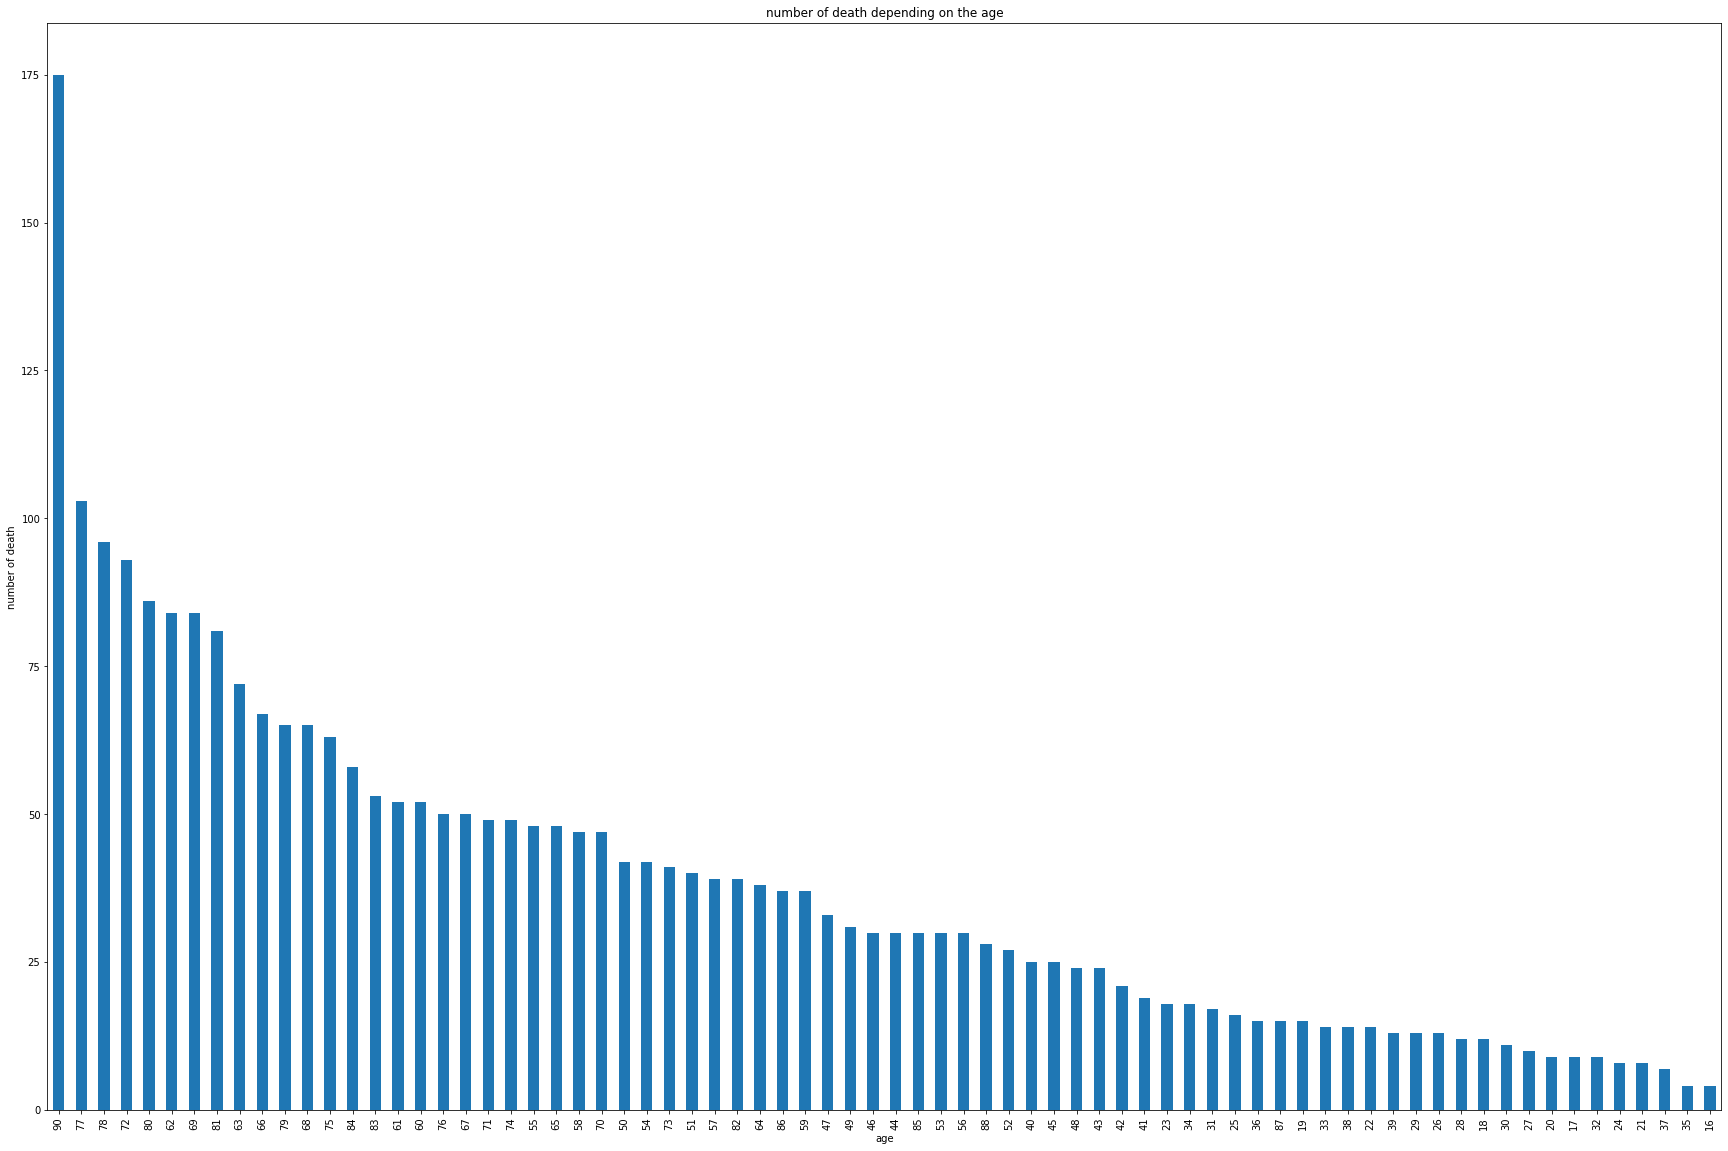

In [6]:
plt.figure(figsize=(30,20))
new_x = X[y==1]["AGE"]

new_x.value_counts().plot.bar()
plt.title("number of death depending on the age")
plt.xlabel("age")
plt.ylabel("number of death")

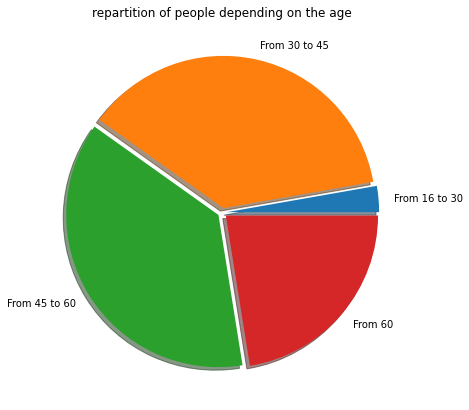

In [7]:
groups = [X[X['AGE'] <=30].shape[0], X[(X['AGE'] > 30) | (X['AGE'] <= 45)].shape[0], X[(X['AGE'] > 45) | (X['AGE'] <= 60)].shape[0], X[X['AGE'] > 60].shape[0]]
group_names = ["From 16 to 30", "From 30 to 45", "From 45 to 60", "From 60"]


plt.figure(figsize=(30,7))
myexplode = [0.03, 0.03, 0.03, 0.03]
plt.pie(groups, labels=group_names, explode=myexplode, shadow = True)
plt.title("repartition of people depending on the age")

plt.show()

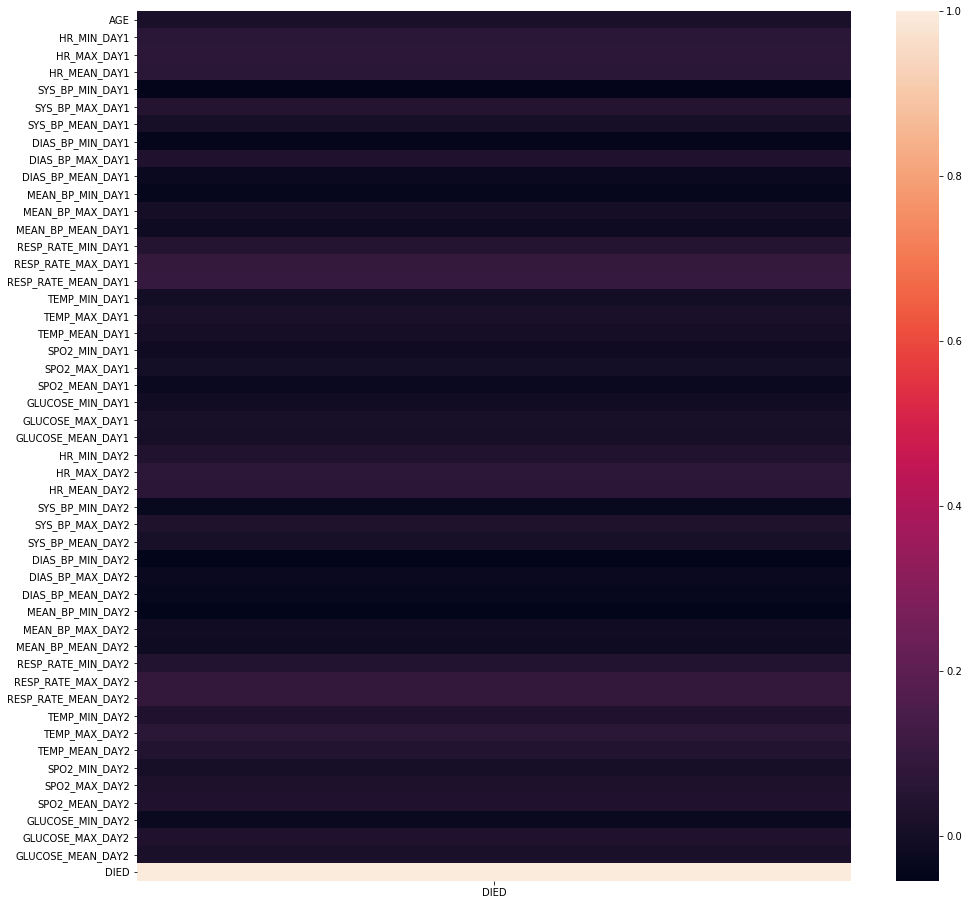

In [19]:
pour_corr = X.copy()

pour_corr = pour_corr[X.columns.values[2:60]]
pour_corr["DIED"] = y

corr = pour_corr.corr()

import seaborn as sns

plt.figure(figsize=(16, 16))

# print(corr)
vals = corr.values[:, -1].reshape(-1,1)

sns.heatmap(vals, 
        xticklabels=[corr.columns[-1]],
        yticklabels=corr.columns)

plt.show()

We can see that there are no direct correlation between these features and the fact that a person die

In [ ]:
corrs = sorted(corr.columns[-1], reverse=True)
print("Top 3 correlated features", corrs[:3])

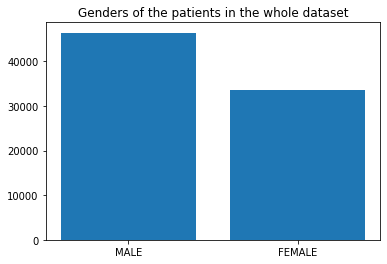

In [20]:
F = [len(X[X["GENDER"] == "M"]) , len(X[X["GENDER"] == "F"])]

plt.bar(["MALE","FEMALE"], F )
plt.title("Genders of the patients in the whole dataset")
plt.show()

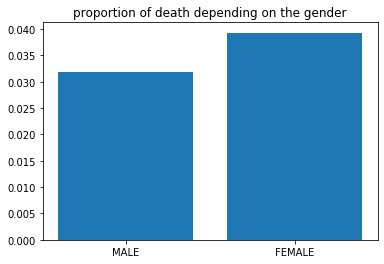

In [21]:
Xa = X.copy()
Xa["death"] = y
Xm = Xa[Xa["GENDER"] == "M"]
Xm = Xm[Xm["death"]==1]

Xf = Xa[Xa["GENDER"] == "F"]
Xf = Xf[Xf["death"]==1]

F2 = [len(Xm),len(Xf)]
F2 = np.divide(F2,F)
plt.title("proportion of death depending on the gender")
plt.bar(["MALE", "FEMALE"], F2)
plt.show()

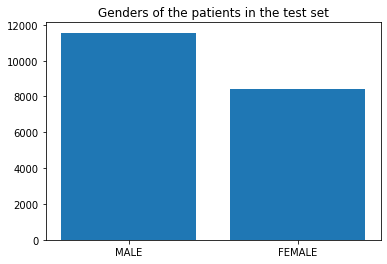

In [22]:
F = [len(X_test[X_test["GENDER"] == "M"]) , len(X_test[X_test["GENDER"] == "F"])]

plt.bar(["MALE","FEMALE"], F )
plt.title("Genders of the patients in the test set")
plt.show()

# 5. Save Predictions

* Use the following code to make predictions and save them as a ZIP file.
* Try to upload this ZIP file into the competition ("Participate > Submit/ View Results > Submit")
* Do your best to be **on top of the leaderboard!**

In [31]:
X_test_encoded_copy = X_test_encoded.copy()

# X_test_encoded_copy.pop('ECodes:Adverseeffectsofmedicalcare')
# X_test_encoded_copy.pop('Otnutritdx')
# X_test_encoded_copy.pop('Othnervdx')

# X_test_encoded_copy = mod.transform(X_test_encoded_copy)

X_test_encoded_copy= normalize(X_test_encoded_copy, use_saved=False)

In [32]:
predictions = model.predict(X_test_encoded_copy).reshape(-1)  # compute predictions (0 and 1)
predictions[predictions <= 0.5] = 0
predictions[predictions>0.5] = 1
predictions_file = "mimic_synthetic_test.csv"
pd.Series(predictions).to_csv(predictions_file, index=False, header = False)
print("Predictions saved.")
t = time.asctime().replace(" ", "_").replace(":", "-")
output_file = "submission_" + t + ".zip"
!zip test_submission.zip mimic_synthetic_test.csv # create a ZIP
with ZipFile(output_file, "w") as z:
    z.write(predictions_file)
print("The submission is ready: {}".format(output_file))

Predictions saved.
  adding: mimic_synthetic_test.csv (deflated 96%)
The submission is ready: submission_Sat_Dec__5_20-19-44_2020.zip


In [ ]:
X_test_encoded_copy.values.shape, x_valid.shape

### Interesting to know!

The dataset doesn't contain actual medical data. We are not allowed to share with you such **confidential data** from critical care patients. To avoid that problem, we replaced the data by **artificial data**. 

In order to have credible data, we have generated them using a **Wasserstein GAN**.

For more information, here is a reference: <br />
Privacy Preserving Synthetic Health Data <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />
https://hal.inria.fr/hal-02160496/document